In [1]:
import torch
from PIL import Image
from os import path 
import torchvision
from torchvision.transforms import ToTensor, Compose, Normalize, Resize, RandomCrop
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation
import matplotlib.pyplot as plt
import scipy
import av

/Users/yau/Documents/sem6/scene_understanding/skateGAN/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
checkpoint_name = 'facebook/maskformer-swin-small-coco'
model = MaskFormerForInstanceSegmentation.from_pretrained(checkpoint_name)
image_processor = MaskFormerImageProcessor.from_pretrained(checkpoint_name)

/Users/yau/Documents/sem6/scene_understanding/skateGAN/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/yau/Documents/sem6/scene_understanding/skateGAN/.venv/lib/python3.11/site-packages/transformers/models/maskformer/image_processing_maskformer.py:412: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/Users/yau/Documents/sem6/scene_understanding/skateGAN/.venv/lib/python3.11/site-packages/transformers/models/maskformer/image_processing_maskformer.py:419: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


In [17]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm


def draw_semantic_segmentation(segmentation):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    # get all the unique numbers
    labels_ids = torch.unique(segmentation).tolist()
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    handles = []
    for label_id in labels_ids:
        label = model.config.id2label[label_id]
        print(label_id, label)
        color = viridis(label_id)
        handles.append(mpatches.Patch(color=color, label=label))
    ax.legend(handles=handles)
    return fig

# draw_semantic_segmentation(semantic_segmentation)

In [18]:
# open bounding box csv
import csv
csv_path = '/Users/yau/Documents/sem6/scene_understanding/skateGAN/data/bounding_box_data.csv'
bboxs = {}
with open(csv_path, 'r') as data:
    count = 0
    for line in csv.reader(data):
        if count == 0:
            count += 1
            continue
        count += 1
        id = line[0].strip()
        bboxs[id] = [int(line[i].strip()) for i in range(3,7)]
        if sum(bboxs[id]) == 0:
            bboxs[id] = None
print(len(bboxs))
print(count)


1095
1096


In [19]:
def square_crop(image, box):
    width = box[2] - box[0]
    height = box[3] - box[1]
    size = max(height, width)
    if height > width:
        crop = torchvision.transforms.functional.crop(image, top=int(box[1]), left=int((box[2] + box[0])/2 - size/2), height=int(size), width=int(size))
    elif height < width:
        crop = torchvision.transforms.functional.crop(image, top=int((box[3] + box[1])/2 - size/2), left=int(box[0]), height=int(size), width=int(size))
    return crop

In [20]:
def get_mask(frame):
    inputs = image_processor(images=frame, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    semantic_segmentation = image_processor.post_process_semantic_segmentation(outputs)[0]
    return semantic_segmentation
    

In [98]:
def process_frame(frame, frame_id):
    # frame: h x w x 
    if frame_id not in bboxs: return
    box = bboxs[frame_id]
    if box == None: return
    cropped_frame = square_crop(frame, box)
    semantic_segmentation = get_mask(cropped_frame)
    # print(semantic_segmentation.shape)
    mask = semantic_segmentation == 0.0
    if torch.sum(mask) == 0:
        return 
    mask = Resize(cropped_frame.shape[1])(mask.unsqueeze(0))
    
    cropped_frame *= mask
    resize = Resize(32)
    cropped_frame = resize(cropped_frame)
    mask = resize(mask)
    legs = torch.cat((cropped_frame, mask), dim=0)
    # print(legs.shape)
    # plt.imshow(cropped_frame.permute(1, 2, 0))
    torch.save(legs, f'data/leg_masks/{frame_id}_legs.pt')


In [99]:
def process_video(video_directory, video_path):
    vid = torchvision.io.read_video(path.join(video_directory, video_path))
    vid_id = video_path.split('.')[0]
    print(f'Processing video {vid_id}.')
    frames = vid[0]
    # transform = Compose([Resize(32)])
    frame_id = 0
    for i in range(frames.shape[0]):
        frame = frames[i,:,:,:].permute(2, 0, 1)
        process_frame(frame, f'{vid_id}_{frame_id}')
        frame_id += 1

In [100]:
from glob import glob
video_directory = '/Users/yau/Documents/sem6/scene_understanding/skateGAN/data/videos'
video_paths = [f.split('/')[-1] for f in glob(path.join(video_directory, '*.mov'))]

for vp in video_paths:
    process_video(video_directory, vp)

/Users/yau/Documents/sem6/scene_understanding/skateGAN/.venv/lib/python3.11/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


Processing video 35.
Processing video 21.
Processing video 20.
Processing video 34.
Processing video 22.
Processing video 36.
Processing video 37.
Processing video 23.
Processing video 27.
Processing video 33.
Processing video 32.
Processing video 26.
Processing video 30.
Processing video 24.
Processing video 18.
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 2

/Users/yau/Documents/sem6/scene_understanding/skateGAN/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1040 valid files found at /Users/yau/Documents/sem6/scene_understanding/skateGAN/data/test_synthetic_frames
1040
hello
torch.Size([1, 3, 32, 32])
952 leg masks found at /Users/yau/Documents/sem6/scene_understanding/skateGAN/data/leg_masks.


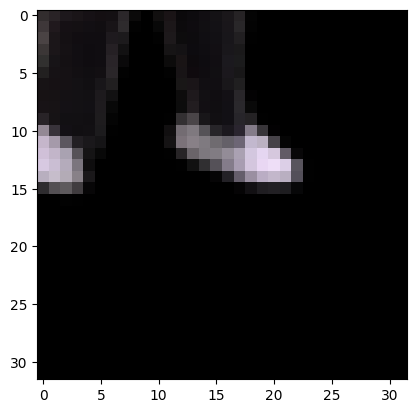

Erosion iterations: 0
image max: 0.0, 0.9686274528503418


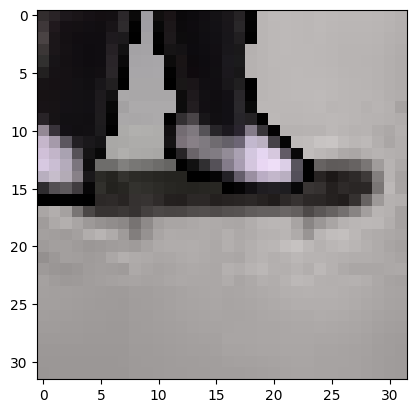

In [1]:
from utils import Add_Legs
from data import skate_data
import torch 
from torchvision.transforms import Compose, ToTensor
import matplotlib.pyplot as plt

# train_transform = Compose([ToTensor(), Add_Legs('data/batb1k/leg_masks'), Normalize(0.5, 0.5)])
# val_transform = Compose([ToTensor(), Add_Legs('data/batb1k/leg_masks')])
val_transform = Compose([ToTensor()])
device = 'cpu'
load_batch_size = 1
# train_dataset = skate_data('data/batb1k/synthetic_frames', 'data/batb1k/synthetic_frame_poses_FIXED.csv', device, train_transform)
val_dataset = skate_data('/Users/yau/Documents/sem6/scene_understanding/skateGAN/data/test_synthetic_frames', '/Users/yau/Documents/sem6/scene_understanding/skateGAN/data/test_synthetic_frame_poses_FIXED.csv', device, val_transform)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, load_batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, load_batch_size, shuffle=True, num_workers=2)
print(len(val_dataset))
for img, dist_label, elev_label, azim_label, _ in val_dataloader:
    print('hello')
    print(img.shape)
    wlegs = Add_Legs('/Users/yau/Documents/sem6/scene_understanding/skateGAN/data/leg_masks', p=1.0)(img)

    plt.imshow(wlegs.squeeze().permute(1, 2, 0))
    plt.show()
    break
